## MNIST Classification using Tensorflow with Keras API

In [1]:
#be sure to have installed tensorflow using conda (c.f. DL-PW-01.pdf , Exercise 1)
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Load and prepare Data

In [2]:
#tf.keras provides different datasets  
#https://www.tensorflow.org/api_docs/python/tf/keras/datasets
mnist = tf.keras.datasets.mnist
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

#we merge data to have the same conditions as for numpy implementation
x = np.concatenate((x_train1, x_test1), axis=0)
y = np.concatenate((y_train1, y_test1), axis=0)

#tf.keras has method to create onehot representation
y = tf.keras.utils.to_categorical(y)

print(x.shape, y.shape)

(70000, 28, 28) (70000, 10)


In [3]:
#select training and test set (random_state sets the seed for reproducible results)

from sklearn import model_selection as ms

#define train and test split
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, 
                                     test_size=0.15, random_state=1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(59500, 28, 28) (10500, 28, 28) (59500, 10) (10500, 10)


In [4]:
#perform normalisation

xmax, xmin = np.max(x_train), np.min(x_train)
x_train = 2*(x_train - xmin) / (xmax - xmin) - 1
x_test = 2*(x_test - xmin) / (xmax - xmin) - 1

### Function used for customised tensorboard feeback

In [5]:
def custom_summary(input_activation):
    """
    this function will be used in the Lamda type layer of the model below to provide customised output
    to tensorboard; the input_activation will be displayed as histogram with the name 'display_name'
    """
    tf.summary.histogram('activation',input_activation)
    return input_activation

### Define Model and Cost

In [6]:
#function to create a 'sequential' models with list of dense layers 
def define_model(hidden_neurons, tensorboard_output):
    """
    create a sequential models of dense layers with the given list of hidden plus output (=10) neurons
    Arguments:
    hidden_neurons -- list of hidden neurons including output (e.g. [150, 50, 10])
    tensorboard_output -- index of layer with activations to be written to tensorboard
    init -- type of initialsation (default 'Glorot')
    """
    
    #initializer = tf.keras.initializers.GlorotNormal()
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        
    layers = []
    layers.append(tf.keras.layers.Flatten(input_shape=(28,28)))
    for i0 in range(len(hidden_neurons)-1): 
        layers.append(tf.keras.layers.Dense(hidden_neurons[i0], activation='sigmoid', kernel_initializer=initializer))
        layers.append(tf.keras.layers.Dropout(0.5))
        if i0 == tensorboard_output:
            layers.append(tf.keras.layers.Lambda(custom_summary))
        
    layers.append(tf.keras.layers.Dense(hidden_neurons[-1], activation="softmax", name="softmax"))
    model = tf.keras.models.Sequential(layers)

    print(model.summary())

    return model

### Define output folder and start training
You have to start tensorboard on the command line (like jupyter notebook) using:

tensorboard --logdir="path to log_dir below"

(double quotations " " are used under windows, check for different conventions on other OS)

In [30]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch >= 0 and epoch <= 20:
        return 0.1
    elif epoch >= 21 and epoch <= 40:
        return 0.05
    elif epoch >= 41 and epoch <=70:
        return 0.01
    else:
        return lr

scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [7]:
#clear everything
tf.keras.backend.clear_session()

#you may have to delete the model to start from scratch
#del model

#output is written to the folder with name defined below
name = 'mnist_tree_hidden_layer_random_normal_jdu'

tensorboard = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        #update_freq='epoch', 
        update_freq=1, #in order to see output of Lambda layer upate_freq must be 1!
        write_graph=True,
        histogram_freq=1)

#define suitable parameters ...
hidden_neurons = [150, 100, 50, 10]
#define layer index with activations to be logged to tensorboard
tensorboard_output = 10

#and create model
model = define_model(hidden_neurons, tensorboard_output)

learning_rate = 0.1
batchsize = 16
epochs = 50

#choose the desired optimisers
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

#Configures the model for training: set the optimiser and define loss function
model.compile(optimizer=optimizer, loss='categorical_crossentropy', #'mean_squared_error'
    metrics=['accuracy'])

#now start training (you can choose the train/validation set split)
history = model.fit(x_train, y_train, verbose = 1,
                        validation_split=0.2, initial_epoch=0,
                        batch_size=batchsize, callbacks=[tensorboard], epochs=epochs)
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               117750    
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

Epoch 48/50
2975/2975 [==============================] - 4s 1ms/step - loss: 0.8383 - accuracy: 0.7369 - val_loss: 0.4768 - val_accuracy: 0.8671
Epoch 49/50
2975/2975 [==============================] - 4s 1ms/step - loss: 0.8274 - accuracy: 0.7391 - val_loss: 0.4771 - val_accuracy: 0.8710
Epoch 50/50
2975/2975 [==============================] - 4s 1ms/step - loss: 0.8017 - accuracy: 0.7485 - val_loss: 0.4845 - val_accuracy: 0.8677


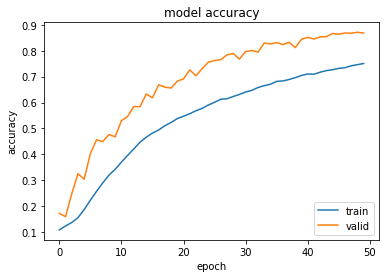

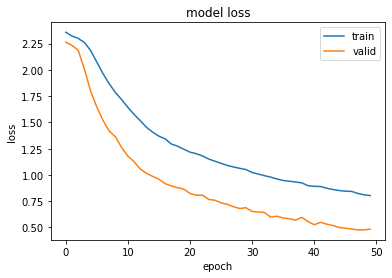

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [9]:
#finally evalute result on test set
#you have to deactivate the Lambda layer (set tensorboard_output to value larger than maximum layer index)
model.evaluate(x_test, y_test)

329/329 [==============================] - 0s 794us/step - loss: 0.4937 - accuracy: 0.8611


[0.49365317821502686, 0.8611428737640381]